In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy as sc
from scipy.sparse import diags, lil_matrix
#import numpy as np
import scipy.sparse as sp

from scipy.sparse.linalg import inv, spsolve
from functools import lru_cache


from scipy.sparse.linalg import inv, splu

In [28]:

@lru_cache(maxsize=128)
def unitcell(w,d,t,e,size):

    base = (w + 1j*d -e)*np.ones(size, dtype=np.complex64)
    hoppings = t * np.ones(size-1,dtype=np.complex64)

    unit = diags([base,hoppings,hoppings],[0,-1,1],format='lil')

    return unit.toarray()

In [27]:

@lru_cache(maxsize=128)
def hopping_znr(size,t):
    dim1 = np.arange(0,size-1,4)
    dim2 = np.arange(3,size,4)
    base = lil_matrix((size, size))

    base[dim1,dim1+1] = t
    base[dim2,dim2-1] = t

    return base.toarray()

In [13]:
from tqdm import tqdm
from joblib import Parallel, delayed
import os
import matplotlib.pyplot as plt

In [14]:
def import_leads(size):
    dos_lead = []
    dir_path = os.path.expanduser(f'~/Desktop/backup/zgnr/size_{int(size)}')
    for w in np.arange(0,3,0.01):
        fn = os.path.join(dir_path, f'leads_{size}_w_{w:.2f}.csv')
        data = np.loadtxt(fn, delimiter=',',dtype=np.complex64)
        dos_lead.append(data)

    return dos_lead

In [72]:


# ----------------------------------------------------------------------
# 1) Precomputed global cache of device_combs per width
# ----------------------------------------------------------------------
DEVICE_COMBS = {}


def _get_device_combs(width: int) -> np.ndarray:
    """
    Return (global cached) device combinations for a given width.
    Each row is (i, j) with i in [0..99] and j in [0..width-1].
    """
    width = int(width)
    if width not in DEVICE_COMBS:
        # Build once, store once
        DEVICE_COMBS[width] = np.stack(
            np.meshgrid(np.arange(100), np.arange(width), indexing="ij"),
            axis=-1
        ).reshape(-1, 2)
    return DEVICE_COMBS[width]


# ----------------------------------------------------------------------
# 2) Cached selection of N random impurity sites for a given config
# ----------------------------------------------------------------------
@lru_cache(maxsize=2048)
def chosen_for_config(n: int, width: int, config: int) -> np.ndarray:
    """
    Return n rows selected deterministically by given config.
    Completely cached.
    """
    n = int(n)
    width = int(width)
    config = int(config)

    device_combs = _get_device_combs(width)

    rng = np.random.RandomState(config)
    idx = rng.choice(len(device_combs), size=n, replace=False)
    return device_combs[idx]


# ----------------------------------------------------------------------
# 3) Factory: returns function(seed) → chosen impurity rows
# ----------------------------------------------------------------------
def possible_combs(n: int, width: int):
    n = int(n)
    width = int(width)

    def combs_for_seed(seed: int):
        return chosen_for_config(n, width, seed)

    return combs_for_seed


# ----------------------------------------------------------------------
# 4) Device builder
# ----------------------------------------------------------------------
def unidevice(w, d, t, e, size, config, n, numberofunitcell, combs_fn=None):
    """
    Build a device Hamiltonian unit with impurities inserted at positions
    determined by 'config'. Uses vectorised assignments where possible.
    """
    if combs_fn is None:
        combs_fn = possible_combs(int(n), int(size))

    # Chosen impurity coordinates
    imps = combs_fn(int(config))
    x = imps[:, 0]
    y = imps[:, 1]

    z = int(numberofunitcell)

    # Base Hamiltonian (already cached inside your unitcell_leads)
    mat = unitcell(w, d, t, e, size)

    # Identify impurities in unitcell z
    mask = (x == z)
    if not np.any(mask):
        return mat  # fast path return

    imp_indices = y[mask]

    # Vectorised diagonal modification
    diag_val = (w + 1j*d - 0.5)
    mat[imp_indices, imp_indices] = diag_val

    return mat


In [18]:
imp = possible_combs(10,11)

In [31]:
size = 17
leads_size = import_leads(17)

In [68]:
def device(w, d, t, e, size, config, n):

    # --- Correct hopping matrix (matches second function) ---
    hopp = hopping_znr(size, t)
    Td = hopp.conj().T
    # ---------------------------------------------------------

    w = round(w, 2)

    # Unitcell inverse
    unit = np.linalg.inv(unitcell(w, d, t, e, size))
    T  = hopping_znr(size, t)
    Td = T.conj().T

    g = unit.copy()
    iden = np.eye(size, dtype=complex)

    # Lead surface Green’s function
    G = leads_size[int(w*100)]

    max_iter = 100
    combs_fn = possible_combs(n, size)

    for i in range(max_iter):
        mat = unidevice(w, d, t, e, size, config, n, i, combs_fn=combs_fn)
        g_d = np.linalg.inv(mat)

        # Dyson update
        A = iden - g_d @ hopp @ G @ Td
        G = np.linalg.solve(A, g_d)

    left_device = G
    right = leads_size[int(w*100)]

    # connect left & right leads
    c_l_1 = iden - left_device @ Td @ right @ Td
    c_l = np.linalg.solve(c_l_1, left_device)

    c_l_2 = iden - right @ Td @ left_device @ Td
    c_r = np.linalg.solve(c_l_2, right)

    # spectral functions
    G_ll = c_l - c_l.conj().T
    G_rr = c_r - c_r.conj().T

    G_lr = right @ Td @ c_l
    Gnon = G_lr - G_lr.conj().T

    term1 = G_ll @ hopp @ G_rr @ Td
    term2 = hopp @ Gnon @ Td @ Gnon

    tr = np.abs(np.trace(term1 - term2))

    return tr


In [73]:
device(0,0.0001,1,0,17,1,10)

np.float64(3.975353202865058)

(0.0, 25.0)

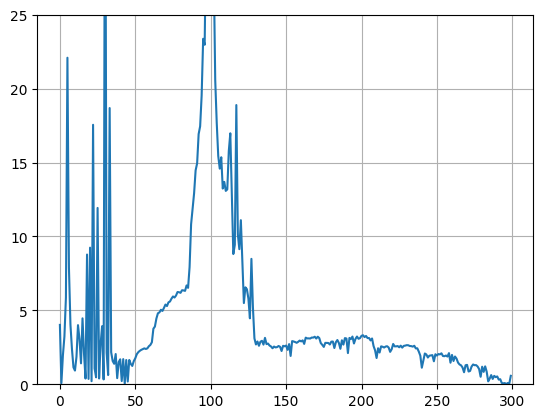

In [78]:
tr = []
for w in np.arange(0,3,0.01):

    il = device(w,0.001,1,0,17,1,10) 

    tr.append(il)



plt.plot(tr)
plt.grid()
plt.ylim(0,25)

In [42]:
type(leads_size)

list